In [1]:
import numpy as np
from scipy.optimize import fsolve
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
import matplotlib.pyplot as plt

# ODEs for the posneg circuit
def Equ1(x, y, beta_x, n):
    return beta_x / (1 + y**n) - x

def Equ2(x, y, beta_y, n):
    return beta_y * x**n / (1 + x**n) - y

def Equs(P, t, params):
    x, y = P
    beta_x, beta_y, n = params
    return np.array([Equ1(x, y, beta_x, n), Equ2(x, y, beta_y, n)])

# Sensitivity functions
def S_betax_yss_analytic(xss, yss, beta_x, beta_y, n):
    numer = n * beta_x * beta_y * xss**(n-1)
    denom = (1 + xss**n)**2 * yss + n**2 * beta_y * xss**n * yss**n + (1 + xss**n)**2 * yss**(1+n)
    return abs(numer / denom)

def S_n_yss_analytic(xss, yss, beta_x, beta_y, n):
    numer = n * beta_y * xss**n * (np.log(xss) + (np.log(xss) - n * np.log(yss)) * yss**n)
    denom = (1 + xss**n)**2 * yss + n**2 * beta_y * xss**n * yss**n + (1 + xss**n)**2 * yss**(1+n)
    return abs(numer / denom)

# Initial guesses for steady state
def generate_initial_guesses(beta_x_val, beta_y_val):
    return [
        np.array([1, 1]),
        np.array([0, 0]),
        np.array([0.3, 12.5]),
        np.array([50.5, 0.9]),
        np.array([67.6, 0.9]),
        np.array([21, 0.9])
    ]

def ssfinder(beta_x_val, beta_y_val, n_val):
    params = np.array([beta_x_val, beta_y_val, n_val])
    for init_guess in generate_initial_guesses(beta_x_val, beta_y_val):
        output, infodict, intflag, _ = fsolve(
            Equs, init_guess, args=(0, params), xtol=1e-12, full_output=True
        )
        xss, yss = output
        fvec = infodict['fvec']
        delta = 1e-8
        dEqudx = (Equs([xss + delta, yss], 0, params) - Equs([xss, yss], 0, params)) / delta
        dEqudy = (Equs([xss, yss + delta], 0, params) - Equs([xss, yss], 0, params)) / delta
        jac = np.transpose(np.vstack((dEqudx, dEqudy)))
        eig = np.linalg.eig(jac)[0]
        instability = np.any(np.real(eig) >= 0)
        if (xss > 0.04 and yss > 0.04 and np.linalg.norm(fvec) < 1e-10 and
                intflag == 1 and not instability):
            return xss, yss
    return np.nan, np.nan

class Sensitivity(ElementwiseProblem):
    def __init__(self):
        super().__init__(
            n_var=3,  # Variables: beta_x, beta_y, n
            n_obj=2,  # Objectives: S_betax_yss, S_n_yss
            n_constr=0,
            xl=np.array([0.001, 0.001, 0.001]),  # Lower bounds
            xu=np.array([50.0, 50.0, 10.0])      # Upper bounds
        )

    def _evaluate(self, x, out, *args, **kwargs):
        beta_x, beta_y, n = x
        xss, yss = ssfinder(beta_x, beta_y, n)
        if np.isnan(xss) or np.isnan(yss):
            out["F"] = [1e5, 1e5]  # Penalize invalid solutions
        else:
            out["F"] = [
                S_betax_yss_analytic(xss, yss, beta_x, beta_y, n),
                S_n_yss_analytic(xss, yss, beta_x, beta_y, n)
            ]

# Run NSGA-II optimization
algorithm = NSGA2(pop_size=1000)
res = minimize(
    Sensitivity(),
    algorithm,
    ('n_gen', 200),
    seed=1,
    verbose=True
)


/tmp/ipykernel_155363/3860384047.py:13: RuntimeWarning: invalid value encountered in scalar power
  return beta_y * x**n / (1 + x**n) - y
/tmp/ipykernel_155363/3860384047.py:10: RuntimeWarning: invalid value encountered in scalar power
  return beta_x / (1 + y**n) - x


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |     1000 |      1 |             - |             -
     2 |     2000 |      1 |  0.000000E+00 |             f
     3 |     3000 |      1 |  2.030617E-15 |             f
     4 |     4000 |      1 |  2.030617E-15 |             f
     5 |     5000 |      1 |  2.030617E-15 |             f
     6 |     6000 |      1 |  2.314229E-15 |             f
     7 |     7000 |      1 |  2.790290E-15 |             f
     8 |     8000 |      1 |  2.891171E-15 |             f
     9 |     9000 |      1 |  2.954761E-15 |             f
    10 |    10000 |      1 |  2.980275E-15 |             f
    11 |    11000 |      1 |  3.003432E-15 |             f
    12 |    12000 |      1 |  3.003833E-15 |             f
    13 |    13000 |      1 |  3.003833E-15 |             f
    14 |    14000 |      1 |  3.006423E-15 |             f
    15 |    15000 |      1 |  3.006534E-15 |             f
    16 |    16000 |      1 |  3.007325E-15 |            

Found 158 non-dominated points in 95.317s


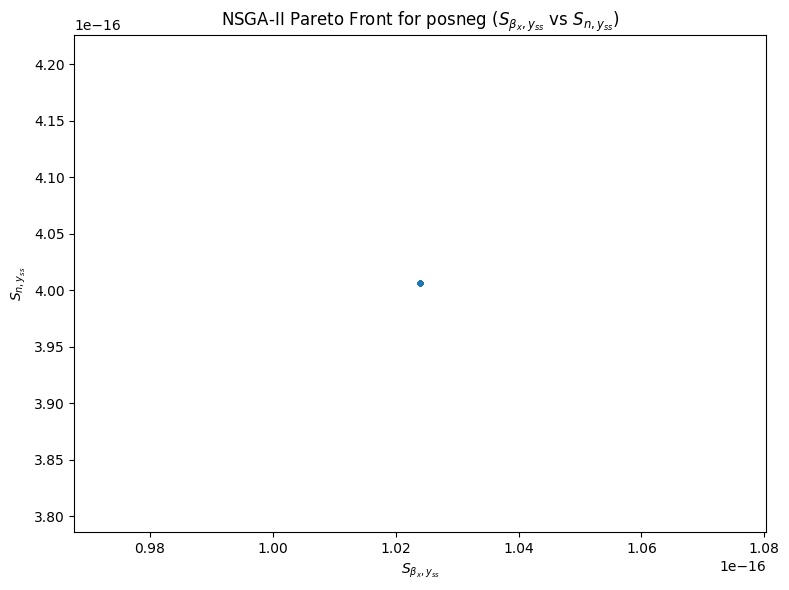

In [ ]:


F = res.F
X = res.X
print(f"Found {F.shape[0]} non-dominated points in {res.exec_time:.3f}s")

plt.figure(figsize=(8, 6))
plt.scatter(F[:, 0], F[:, 1], s=10)
plt.xlabel(r'$S_{\beta_x,y_{ss}}$')
plt.ylabel(r'$S_{n,y_{ss}}$')
plt.title(r'NSGA-II Pareto Front for posneg ($S_{\beta_x,y_{ss}}$ vs $S_{n,y_{ss}}$)')
plt.tight_layout()
plt.show()